In [42]:
import pandas as pd
import numpy as np
import re, string
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, precision_score,
                             recall_score, f1_score)

import joblib
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [43]:
data = pd.read_csv('/content/spam.csv', encoding='latin-1')

In [44]:
data.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [45]:
data.tail(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5562,ham,Ok lor... Sony ericsson salesman... I ask shuh...,NaN,NaN,NaN
5563,ham,Ard 6 like dat lor.,NaN,NaN,NaN
5564,ham,Why don't you wait 'til at least wednesday to ...,NaN,NaN,NaN
5565,ham,Huh y lei...,NaN,NaN,NaN
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,NaN,NaN,NaN
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


In [46]:
print("Shape:", data.shape)
print("Columns:", data.columns.tolist())

Shape: (5572, 5)
Columns: ['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']


In [47]:
data = data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
print("Shape after dropping columns:", data.shape)
print("Columns after dropping columns:", data.columns.tolist())

Shape after dropping columns: (5572, 2)
Columns after dropping columns: ['v1', 'v2']


In [48]:
if 'v1' in data.columns and 'v2' in data.columns:
    data = data.rename(columns={'v1':'label', 'v2':'text'})

In [49]:
data.columns

Index(['label', 'text'], dtype='object')

In [50]:
data = data.dropna(subset=['text', 'label'])
data = data.drop_duplicates(subset=['text']).reset_index(drop=True)
print("After cleanup shape:", data.shape)

After cleanup shape: (5169, 2)


In [51]:
def label_to_num(x):
    s = str(x).strip().lower()
    if s in ('spam','1','true','t','yes','y'):
        return 1
    if s in ('ham','0','false','f','no','n','not spam','not_spam'):
        return 0
    return np.nan

data['label_num'] = data['label'].apply(label_to_num)
data = data.dropna(subset=['label_num']).copy()
data['label_num'] = data['label_num'].astype(int)

print(data['label_num'].value_counts())

label_num
0    4516
1     653
Name: count, dtype: int64


In [52]:
import nltk
nltk.download('punkt')
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 2]
    return ' '.join(tokens)

print(clean_text("Hello! This is a test email. Visit http://example.com or contact me at test@mail.com 12345"))

hello test email visit contact


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [53]:
data['clean_text'] = data['text'].apply(clean_text)
display(data[['text','clean_text']].head())

,text,clean_text
0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis great world...
1,Ok lar... Joking wif u oni...,lar joking wif oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win cup final tkts may te...
3,U dun say so early hor... U c already then say...,dun say early hor already say
4,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though


In [54]:
data.head()

,label,text,label_num,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",0,jurong point crazy available bugis great world...
1,ham,Ok lar... Joking wif u oni...,0,lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry wkly comp win cup final tkts may te...
3,ham,U dun say so early hor... U c already then say...,0,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah dont think go usf life around though


In [55]:
from sklearn.model_selection import train_test_split

X = data['clean_text']
y = data['label_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 4135
Testing samples: 1034


In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1,2))),
    ('clf', MultinomialNB())
])

pipeline_nb.fit(X_train, y_train)

y_pred_nb = pipeline_nb.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb, target_names=['ham','spam']))

Naive Bayes Accuracy: 0.971953578336557

Classification Report:
               precision    recall  f1-score   support

         ham       0.97      1.00      0.98       903
        spam       0.98      0.79      0.88       131

    accuracy                           0.97      1034
   macro avg       0.98      0.90      0.93      1034
weighted avg       0.97      0.97      0.97      1034



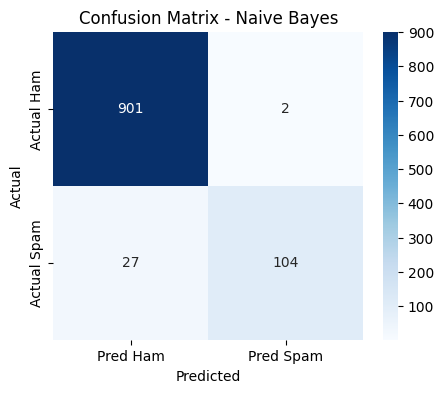

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred Ham','Pred Spam'],
            yticklabels=['Actual Ham','Actual Spam'])
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [58]:
from sklearn.linear_model import LogisticRegression

pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=1000))
])

pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr, target_names=['ham','spam']))

Logistic Regression Accuracy: 0.9574468085106383

Classification Report:
               precision    recall  f1-score   support

         ham       0.96      1.00      0.98       903
        spam       0.97      0.69      0.80       131

    accuracy                           0.96      1034
   macro avg       0.96      0.84      0.89      1034
weighted avg       0.96      0.96      0.95      1034



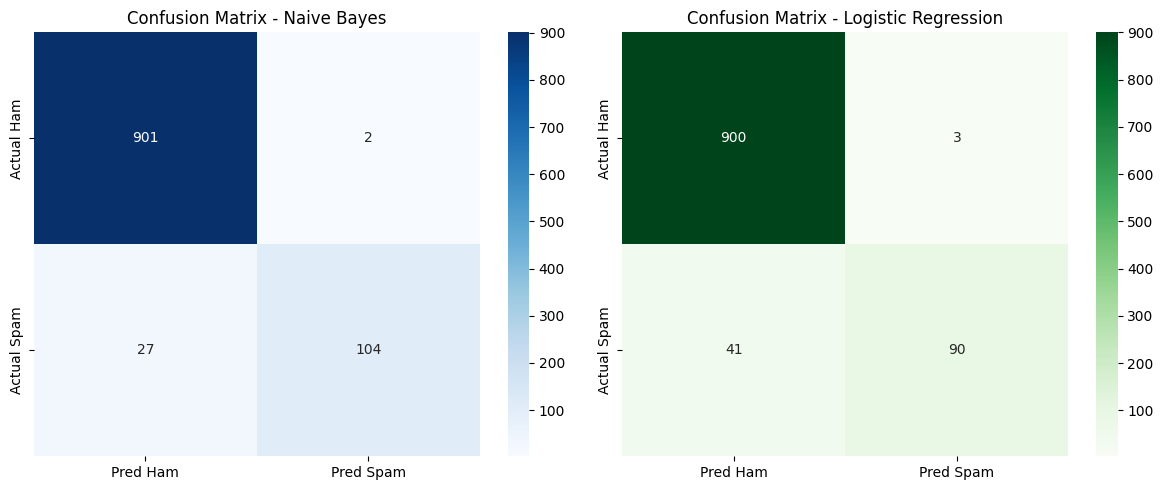

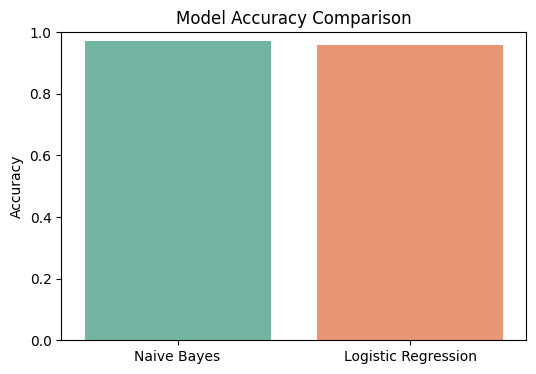

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Confusion Matrices
cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_lr = confusion_matrix(y_test, y_pred_lr)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred Ham','Pred Spam'],
            yticklabels=['Actual Ham','Actual Spam'],
            ax=axes[0])
axes[0].set_title("Confusion Matrix - Naive Bayes")

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Pred Ham','Pred Spam'],
            yticklabels=['Actual Ham','Actual Spam'],
            ax=axes[1])
axes[1].set_title("Confusion Matrix - Logistic Regression")

plt.tight_layout()
plt.show()

# Accuracy Scores
acc_nb = accuracy_score(y_test, y_pred_nb)
acc_lr = accuracy_score(y_test, y_pred_lr)

# Accuracy Plot (Fixed Warning)
plt.figure(figsize=(6,4))
sns.barplot(x=["Naive Bayes", "Logistic Regression"],
            y=[acc_nb, acc_lr],
            hue=["Naive Bayes", "Logistic Regression"],  # ✅ Added hue
            palette="Set2",
            legend=False)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

In [60]:
from sklearn.ensemble import RandomForestClassifier

pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1,2))),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])

pipeline_rf.fit(X_train, y_train)

y_pred_rf = pipeline_rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, target_names=['ham','spam']))

Random Forest Accuracy: 0.9738878143133463

Classification Report:
               precision    recall  f1-score   support

         ham       0.97      1.00      0.99       903
        spam       0.97      0.82      0.89       131

    accuracy                           0.97      1034
   macro avg       0.97      0.91      0.94      1034
weighted avg       0.97      0.97      0.97      1034



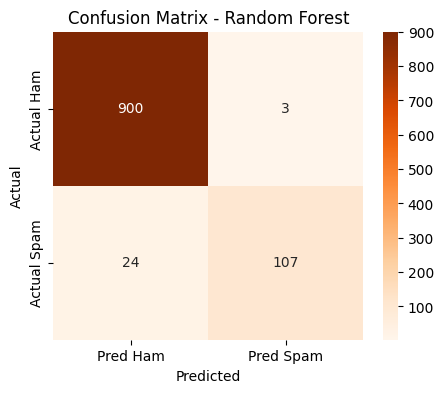

In [61]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Pred Ham','Pred Spam'],
            yticklabels=['Actual Ham','Actual Spam'])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [62]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

pipelines = {
    "Naive Bayes": Pipeline([
        ('tfidf', TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1,2))),
        ('clf', MultinomialNB())
    ]),
    "Logistic Regression": Pipeline([
        ('tfidf', TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1,2))),
        ('clf', LogisticRegression(max_iter=1000))
    ]),
    "Random Forest": Pipeline([
        ('tfidf', TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1,2))),
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
}

results = {}
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred)
    }

results

{'Naive Bayes': {'Accuracy': 0.971953578336557,
  'Precision': 0.9811320754716981,
  'Recall': 0.7938931297709924,
  'F1 Score': 0.8776371308016878},
 'Logistic Regression': {'Accuracy': 0.9574468085106383,
  'Precision': 0.967741935483871,
  'Recall': 0.6870229007633588,
  'F1 Score': 0.8035714285714286},
 'Random Forest': {'Accuracy': 0.9748549323017408,
  'Precision': 0.972972972972973,
  'Recall': 0.8244274809160306,
  'F1 Score': 0.8925619834710744}}

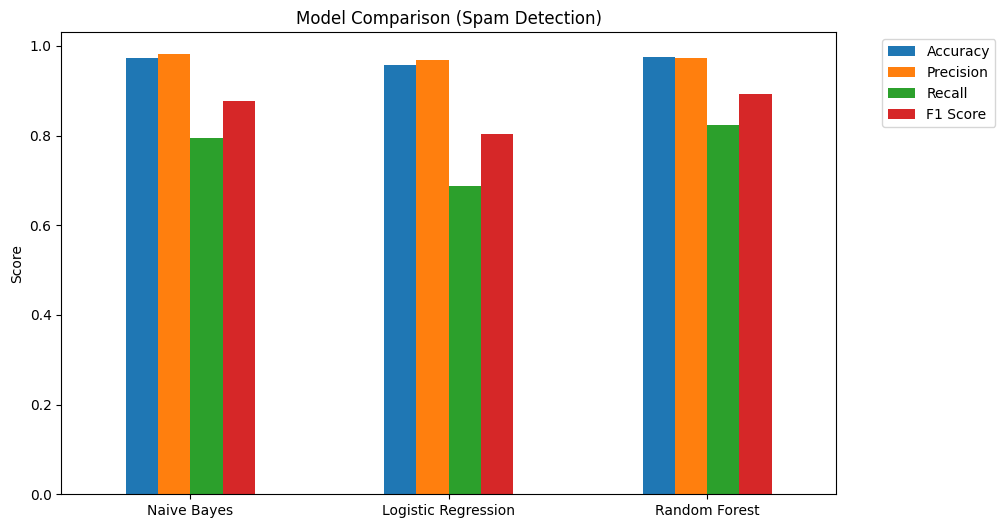

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

results_df = pd.DataFrame(results).T

results_df.plot(kind="bar", figsize=(10,6))
plt.title("Model Comparison (Spam Detection)")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

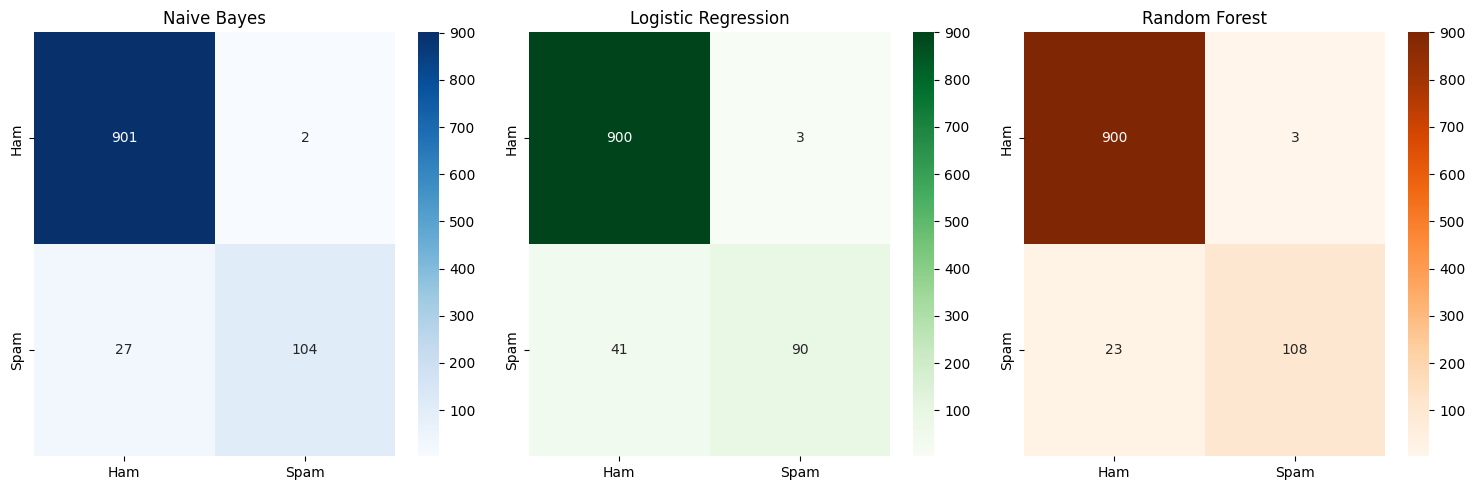

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred_nb = pipelines["Naive Bayes"].predict(X_test)
y_pred_lr = pipelines["Logistic Regression"].predict(X_test)
y_pred_rf = pipelines["Random Forest"].predict(X_test)

cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_rf = confusion_matrix(y_test, y_pred_rf)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues", ax=axes[0], xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
axes[0].set_title("Naive Bayes")

sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Greens", ax=axes[1], xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
axes[1].set_title("Logistic Regression")

sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Oranges", ax=axes[2], xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
axes[2].set_title("Random Forest")

plt.tight_layout()
plt.show()

In [65]:
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1,2))

X_tfidf = tfidf.fit_transform(X)

nb_model = MultinomialNB()

cv_scores = cross_val_score(nb_model, X_tfidf, y, cv=5, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))
print("Standard Deviation:", np.std(cv_scores))

Cross-validation scores: [0.97582205 0.96518375 0.97001934 0.9729207  0.97483059]
Mean Accuracy: 0.9717552863811438
Standard Deviation: 0.003835434911694756


In [66]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf = TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1,2)) # Assuming this is done in a previous cell

X_tfidf = tfidf.fit_transform(X)

nb_model = MultinomialNB()
nb_model.fit(X_tfidf, y)

feature_names = tfidf.get_feature_names_out()

log_prob_ratios = nb_model.feature_log_prob_[1] - nb_model.feature_log_prob_[0]

top_spam_idx = np.argsort(log_prob_ratios)[-20:]
top_spam_words = feature_names[top_spam_idx]

top_ham_idx = np.argsort(log_prob_ratios)[:20]
top_ham_words = feature_names[top_ham_idx]

print("Top Spam Words:\n", top_spam_words)
print("\nTop Ham Words:\n", top_ham_words)

Top Spam Words:
 ['tscs' 'voucher' 'collection' 'entry' 'claim call' 'valid' 'weekly' 'tc'
 'nokia' 'service' 'ringtone' 'pmin' 'awarded' 'urgent' 'pobox'
 'guaranteed' 'ppm' 'tone' 'prize' 'claim']

Top Ham Words:
 ['ltgt' 'ill' 'lor' 'home' 'later' 'going' 'say' 'got' 'come' 'lol'
 'thats' 'much' 'way' 'ask' 'wat' 'yeah' 'anything' 'said' 'something'
 'sure']


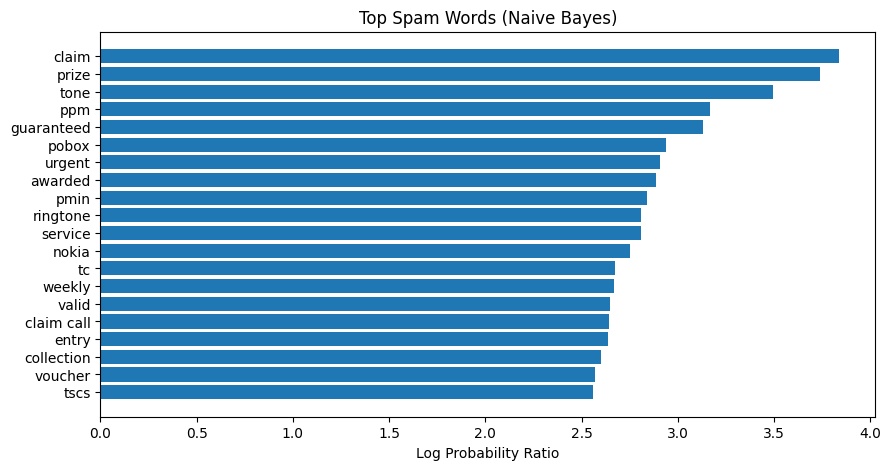

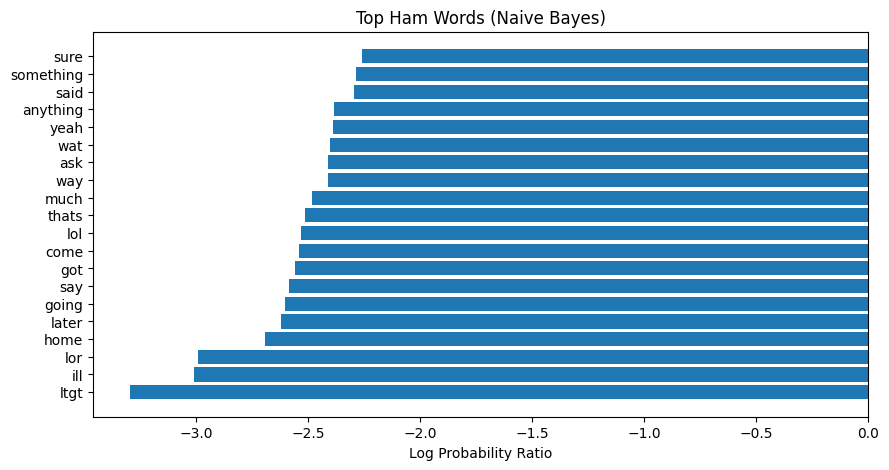

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.barh(top_spam_words, log_prob_ratios[top_spam_idx])
plt.title("Top Spam Words (Naive Bayes)")
plt.xlabel("Log Probability Ratio")
plt.show()

plt.figure(figsize=(10,5))
plt.barh(top_ham_words, log_prob_ratios[top_ham_idx])
plt.title("Top Ham Words (Naive Bayes)")
plt.xlabel("Log Probability Ratio")
plt.show()

In [68]:
import joblib
joblib.dump(nb_model, "spam_classifier_nb.pkl")

joblib.dump(tfidf, "vectorizer.pkl")

print("Model and vectorizer saved successfully!")

Model and vectorizer saved successfully!


In [69]:
import joblib

loaded_model = joblib.load("spam_classifier_nb.pkl")
loaded_vectorizer = joblib.load("vectorizer.pkl")

print("Model and vectorizer loaded successfully!")

Model and vectorizer loaded successfully!


In [70]:
def predict_email(text):
    text_vectorized = loaded_vectorizer.transform([text])

    prediction = loaded_model.predict(text_vectorized)[0]
    return "Spam" if prediction == 1 else "Ham"

In [71]:
print(predict_email("Congratulations! You won a lottery, claim your prize now!"))
print(predict_email("Hey, are we meeting at 5pm tomorrow?"))

Spam
Ham


In [72]:
import joblib
joblib.dump(nb_model, "spam_classifier_nb.pkl")
joblib.dump(tfidf, "vectorizer.pkl")

['vectorizer.pkl']